### oldAIboy's project: Transformer for sentiment analysis

In [2]:
############################### Basic setup##################################
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('drive/MyDrive/oldAIboy/firstAIproject')

############################# import dependencies###################################
import os
import pandas as pd
import numpy as np

## import for data preparation
import pickle
from torch.utils.data import DataLoader, TensorDataset, Dataset

###section 1 build tokens
from gensim.utils import simple_preprocess
from gensim import corpora
### Section 2, create tokenizer based on hugging face, and build the dataloaders
from gensim import downloader
from transformers import BertTokenizer
!pip install datasets==2.14.4
from datasets import load_dataset, Split
from datasets import Dataset
### Section 4 & 5
import torch
import torch.nn as nn
from transformer_modules.transformer import *
from transformer_modules.stepbystep_v5 import StepByStep
# from seq2seq import *
# from stepbystep.v4 import StepByStep

c:\Users\randu\Miniconda3\envs\ai_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Section 1. Data Preparation

#### Data Preparation 1 - organize the data

In [3]:
%%time
##Pull in the data
rawdata = pd.read_csv('IMDB Dataset.csv')

###section 1 build dictionary stoi (this will handle transforming strings to indices)
sentlist = rawdata['review'].tolist()
words = [simple_preprocess(sent) for sent in sentlist] #use gensim.simple_preprocess to make tokens
stoi = corpora.Dictionary(words)  #dictionary is a set of unique tokens, in the format of gansim dict
#stoi.token2id

CPU times: total: 50.4 s
Wall time: 55.1 s


In [4]:
##create data label
dataset = Dataset.from_pandas(rawdata)
def create_label(row):
    sentiment_label = int(row['sentiment'] == 'positive')
    return {'labels': sentiment_label}
dataset = dataset.map(create_label)

Map: 100%|██████████| 50000/50000 [00:05<00:00, 9090.87 examples/s] 


In [5]:
dataset

Dataset({
    features: ['review', 'sentiment', 'labels'],
    num_rows: 50000
})

In [6]:
## show one example of the movie review data
dataset[0]

{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

#### Data Preparation 2 - build tokenizer by using GLOVE and huggingface

In [6]:
## set up hyper-parameters
max_len = 300
batch_size = 32

### Section 2, create tokenizer based on GLOVE by using huggingface
glove = downloader.load('glove-wiki-gigaword-50')
##save embedding's vocab to a plain txt file, then utilize HF's tokenizer
to_add = ['[PAD]', '[UNK]']
words = glove.index_to_key
words = to_add + words
folder = os.getcwd()
# only need to run this once - create the local txt file
# with open(os.path.join(folder, 'vocab2.txt'), 'w') as f:
#         for word in words:
#             f.write(f'{word}\n')

##* Create the tokenizer based on local txt file
glove_tokenizer = BertTokenizer('vocab2.txt')

[==================================================] 100.0% 66.0/66.0MB downloaded


#### Data Preparation 3 - Implement the text tokenization and create data batches through PyTorch's DataLoader

In [11]:
##create the tokenizer by utilizing Huggingface's API, only need to run once
# ##shuffle and split
# shuffled_dataset = dataset.shuffle(seed=42)
# split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
# train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

# ##Build the tokens based on glove_tokenizer
# train_ids = glove_tokenizer(train_dataset['review'], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']
# train_labels = torch.as_tensor(train_dataset['labels']).float().view(-1, 1)
# test_ids = glove_tokenizer(test_dataset['review'], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']
# test_labels = torch.as_tensor(test_dataset['labels']).float().view(-1, 1)

# ##save tokens to the disk for future use
# saveObject = (train_ids, train_labels, test_ids, test_labels)
# pickle.dump(saveObject, open('data_tokens_300seq.pickle', 'wb'))

with open("data_tokens_300seq.pickle", "rb") as f:
   train_ids, train_labels, test_ids, test_labels = pickle.load(f)

##create data batch by using DataLoader
generator = torch.Generator()
train_tensor_dataset = TensorDataset(train_ids, train_labels)
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size)


#### Data Preparation 4 - Create the embedding layer by using GLOVE (An pretrained text embedding)

In [6]:
## Section4: Build the extended embedding
special_embeddings = np.zeros((2, glove.vector_size))
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)

# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)


### Section 2. Model training, inference, and evaluation

#### Model 1 - design and architecture

In [13]:
## Section 1: custom build a classifier based on transformer model
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

#### Model 2 - model training & evaluation (200 epochs / lr 1e-5)

In [14]:
## set up hyper-parameters
n_layers = 4
n_heads = 5
ff_units=128

Training:   0%|          | 1/201 [00:21<1:10:25, 21.13s/it, train_loss=0.6935, val_loss=0.6811]


Epoch 0/201
Training loss: 0.6935
Validation loss: 0.6811
------------------------------


Training:  10%|█         | 21/201 [07:23<1:03:16, 21.09s/it, train_loss=0.4015, val_loss=0.3945]


Epoch 20/201
Training loss: 0.4015
Validation loss: 0.3945
------------------------------


Training:  20%|██        | 41/201 [14:25<56:21, 21.13s/it, train_loss=0.3694, val_loss=0.3648]


Epoch 40/201
Training loss: 0.3694
Validation loss: 0.3648
------------------------------


Training:  30%|███       | 61/201 [21:27<49:12, 21.09s/it, train_loss=0.3500, val_loss=0.3482]


Epoch 60/201
Training loss: 0.3500
Validation loss: 0.3482
------------------------------


Training:  40%|████      | 81/201 [28:29<42:11, 21.10s/it, train_loss=0.3361, val_loss=0.3392]


Epoch 80/201
Training loss: 0.3361
Validation loss: 0.3392
------------------------------


Training:  50%|█████     | 101/201 [35:31<35:06, 21.07s/it, train_loss=0.3244, val_loss=0.3329]


Epoch 100/201
Training loss: 0.3244
Validation loss: 0.3329
------------------------------


Training:  60%|██████    | 121/201 [42:33<28:08, 21.11s/it, train_loss=0.3165, val_loss=0.3281]


Epoch 120/201
Training loss: 0.3165
Validation loss: 0.3281
------------------------------


Training:  70%|███████   | 141/201 [49:36<21:06, 21.11s/it, train_loss=0.3096, val_loss=0.3261]


Epoch 140/201
Training loss: 0.3096
Validation loss: 0.3261
------------------------------


Training:  80%|████████  | 161/201 [56:37<14:03, 21.09s/it, train_loss=0.3034, val_loss=0.3224]


Epoch 160/201
Training loss: 0.3034
Validation loss: 0.3224
------------------------------


Training:  90%|█████████ | 181/201 [1:03:39<07:02, 21.10s/it, train_loss=0.2962, val_loss=0.3210]


Epoch 180/201
Training loss: 0.2962
Validation loss: 0.3210
------------------------------


Training:  90%|█████████ | 181/201 [1:04:00<07:04, 21.22s/it, train_loss=0.2967, val_loss=0.3207]


Early stopping triggered after 182 epochs
CPU times: user 1h 4min 5s, sys: 10.7 s, total: 1h 4min 15s
Wall time: 1h 4min


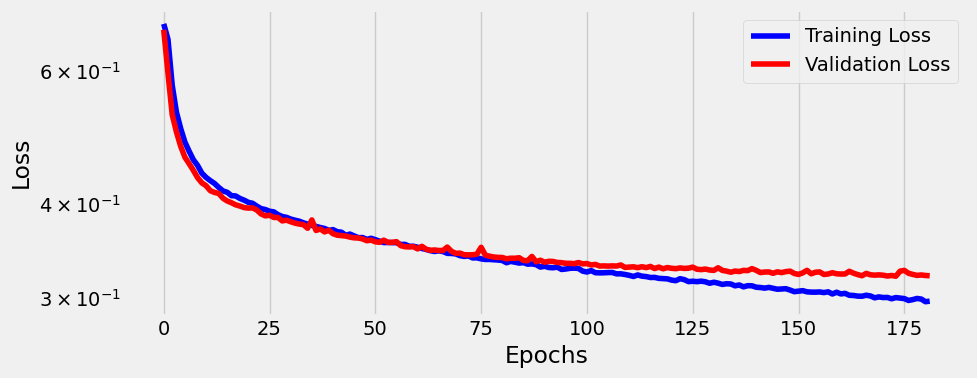

In [11]:
%%time
## lower the lr as 1e-5 and epoch 75 to combat with overfitting
torch.manual_seed(33)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(201,print_interval=20, patience=8, min_delta=0)

fig = sbs_transf.plot_losses()

##### Model evaluation

In [15]:
## implement the model inference

device = 'cuda' if torch.cuda.is_available() else 'cpu'

logits_tensor = torch.empty((0, 1), device=device)  # Create an empty tensor on the device

# Loop through the test data in batches of 100
for i in range(0, len(test_ids), 100):
    # Extract a batch of 100 data points
    batch = test_ids[i:i + 100].to(device)

    # Perform model inference
    with torch.no_grad():  # Disable gradient calculation during inference
        logits = sbs_transf.model(batch)

    # Append the logits to the list
    logits_tensor = torch.cat([logits_tensor, logits], dim=0)  # Concatenate logits to the tensor

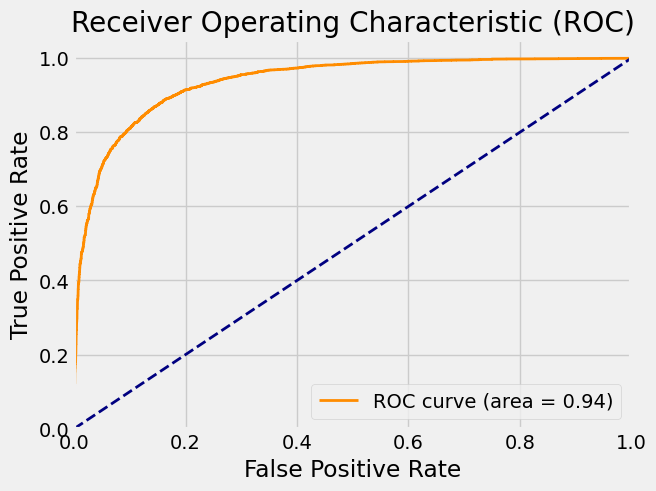

AUC Score: 0.9381996647785458
Accuracy Score: 0.861
Logged Loss: 0.3208173347797447


In [16]:
## Evaluate model performance
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, log_loss
import numpy as np

# Assuming you have:
# - logits_tensor: a PyTorch tensor containing the inference logits
# - test_labels: a PyTorch tensor containing the true labels

# 1. Convert logits to probabilities
probabilities = torch.sigmoid(logits_tensor).cpu().detach().numpy()

# 2. Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities >= 0.5).astype(int)

# 3. Calculate AUC score
auc_score = roc_auc_score(test_labels.cpu().detach().numpy(), probabilities)

# 4. Calculate accuracy score
accuracy = accuracy_score(test_labels.cpu().detach().numpy(), predictions)

# 5. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), probabilities)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 7. Calculate logged loss
# Convert test_labels to NumPy and ensure it's in the correct shape
test_labels_np = test_labels.cpu().detach().numpy()
# test_labels_np = test_labels_np.reshape(-1, 1)  # Reshape if necessary (e.g., if it's a 1D array)
# test_labels_np = test_labels_np.astype(int)  # Ensure data type is int

# Clip probabilities to avoid log(0) errors
probabilities_clipped = np.clip(probabilities, 1e-15, 1 - 1e-15)

logged_loss = log_loss(test_labels_np, probabilities_clipped)

# Print the results
print(f"AUC Score: {auc_score}")
print(f"Accuracy Score: {accuracy}")
print(f"Logged Loss: {logged_loss}")

#### Model 3 - Model save, load, inference

In [13]:
# Save the model - Assuming you have:
# - model: your trained PyTorch model
# - PATH: the file path where you want to save the model (e.g., 'my_model.pth')

# 1. Save the model's state_dict
torch.save(sbs_transf.model.state_dict(), 'deep_model_200epochs_trained1227.pth')

In [12]:
## load the model and implement inference
## set up hyper-parameters
n_layers = 4
n_heads = 5
ff_units=128

# Load the model
# Assuming you have:
# - model: an instance of the same model class that you saved
 ## (need to run the model configuration again)
# - PATH: the file path where the model is saved

# 1. Load the saved state_dict
state_dict = torch.load('deep_model_200epochs_trained1227.pth')

# 2. Load the state_dict into your model
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)

model.load_state_dict(state_dict)

# 3. Set the model to evaluation mode (if needed)
model.eval()

<ipython-input-12-b40398f44b2f>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('deep_model_200epochs_trained1227.pth')


TransfClassifier(
  (encoder): EncoderTransf(
    (pe): PositionalEncoding()
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (self_attn_heads): MultiHeadedAttention(
          (linear_query): Linear(in_features=50, out_features=50, bias=True)
          (linear_key): Linear(in_features=50, out_features=50, bias=True)
          (linear_value): Linear(in_features=50, out_features=50, bias=True)
          (linear_out): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Sequential(
          (0): Linear(in_features=50, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=50, bias=True)
        )
        (sublayers): ModuleList(
          (0-1): 2 x SubLayerWrapper(
            (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
     

In [13]:
%%time
## implement the model inference
device = 'cuda' if torch.cuda.is_available() else 'cpu'

logits_tensor = torch.empty((0, 1), device=device)  # Create an empty tensor on the device

# Loop through the test data in batches of 100
for i in range(0, len(test_ids), 100):
    # Extract a batch of 100 data points
    batch = test_ids[i:i + 100].to(device)

    # Perform model inference
    model.to(device)
    with torch.no_grad():  # Disable gradient calculation during inference
        logits = model(batch)

    # Append the logits to the list
    logits_tensor = torch.cat([logits_tensor, logits], dim=0)  # Concatenate logits to the tensor

CPU times: user 1.53 s, sys: 4.99 ms, total: 1.54 s
Wall time: 1.53 s


### Section 3. Trying to understand self-attention mechanism by looking into the attention matrix

#### 3.1 example1 - an positive example

In [46]:
##randomly pick one reivew
reviewno = 2
dataset[reviewno]

{'review': 'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.',
 'sentiment': 'positive',
 'labels': 1}

In [47]:
## obtain the tokens
tokens = glove_tokenizer(dataset['review'][reviewno], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']

# Perform model inference & produce the probability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
with torch.no_grad():  # Disable gradient calculation during inference
  logits = model(tokens.to(device))
print(f'logits are {logits}')


logits are tensor([[3.6142]], device='cuda:0')


In [48]:
# check the attention matrix matched to the review texts
decoded_text = glove_tokenizer.decode(tokens[0])
attscores = model.encoder.layers[3].self_attn_heads.alphas.squeeze()[:,:,0]

# Split decoded_text into words
words = decoded_text.split()

# Create a list to store the data for the DataFrame
data = []

# Assuming 'attscores' has 5 dimensions
num_dimensions = attscores.shape[0]

# Check if the number of dimensions matches the expected number
if num_dimensions != 5:
    print(f"Warning: attscores has {num_dimensions} dimensions, expected 5. Using available dimensions")

# Iterate through the words and create rows for the DataFrame
for i, word in enumerate(words):
  if i < len(attscores[0]): # Check to make sure we don't go out of bounds
    row_data = [word]  # First column is the current word
    for j in range(min(5, num_dimensions)): # Iterate through the attention dimensions
      row_data.append(attscores[j][i].item()) # Append the attention score of the current word for the current attention head
    data.append(row_data)
  else:
    break # Stop if we reach the end of the attention scores

# Create the DataFrame
columns = ['word']
for i in range(min(5, num_dimensions)):
    columns.append(f'head_{i+1}') # Change dimension_n to head_n

df = pd.DataFrame(data, columns=columns)

df

,word,head_1,head_2,head_3,head_4,head_5
0,i,0.000084,0.007514,0.005693,0.000905,0.001485
1,thought,0.002761,0.001331,0.004802,0.004652,0.007348
2,this,0.002185,0.000751,0.002969,0.005629,0.004045
3,was,0.004294,0.000954,0.003950,0.007287,0.006564
4,a,0.005687,0.000886,0.004212,0.006755,0.003768
...,...,...,...,...,...,...
188,to,0.004628,0.000875,0.003580,0.007128,0.006958
189,go,0.005418,0.000951,0.004238,0.006766,0.004120
190,see,0.018599,0.014465,0.002517,0.003462,0.005525
191,with,0.005331,0.001137,0.002640,0.004827,0.007364


##### Note: The attention was well applied on some words such as 'wittier', which indicates the positive review

In [52]:
# Filter rows where any value in 'head_1' to 'head_5' is greater than 0.008
scorethresh = 0.008
df_filtered = df[(df['head_1'] > scorethresh) | (df['head_2'] > scorethresh) | (df['head_3'] > scorethresh) | (df['head_4'] > scorethresh) | (df['head_5'] > scorethresh)]
df_filtered

,word,head_1,head_2,head_3,head_4,head_5
6,way,0.004088,0.002633,0.008756,0.008101,0.005129
23,watching,0.009088,0.002146,0.003740,0.004194,0.003550
30,plot,0.010556,0.002522,0.005300,0.005254,0.004989
39,the,0.003489,0.004738,0.005223,0.003735,0.008639
48,suspected,0.002492,0.000782,0.002867,0.004064,0.008383
53,some,0.012558,0.000980,0.002442,0.004325,0.004024
64,point,0.001553,0.002270,0.003674,0.004144,0.009021
69,i,0.002095,0.001677,0.004602,0.009665,0.003830
79,fully,0.004008,0.000408,0.003026,0.010472,0.004541
84,style,0.002617,0.000760,0.002879,0.004603,0.008247


#### 3.2 example2 - an negative example

In [53]:
##randomly pick one reivew
reviewno = 3
dataset[reviewno]

{'review': "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'sentiment': 'negative',
 'labels': 0}

In [54]:
## obtain the tokens
tokens = glove_tokenizer(dataset['review'][reviewno], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']

# Perform model inference & produce the probability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
with torch.no_grad():  # Disable gradient calculation during inference
  logits = model(tokens.to(device))
print(f'logits are {logits}')

logits are tensor([[-2.9592]], device='cuda:0')


In [55]:
# Assuming 'decoded_text' and 'attscores' are defined from the previous code
decoded_text = glove_tokenizer.decode(tokens[0])
attscores = model.encoder.layers[3].self_attn_heads.alphas.squeeze()[:,:,0]

# Split decoded_text into words
words = decoded_text.split()

# Create a list to store the data for the DataFrame
data = []

# Assuming 'attscores' has 5 dimensions
num_dimensions = attscores.shape[0]

# Check if the number of dimensions matches the expected number
if num_dimensions != 5:
    print(f"Warning: attscores has {num_dimensions} dimensions, expected 5. Using available dimensions")

# Iterate through the words and create rows for the DataFrame
for i, word in enumerate(words):
  if i < len(attscores[0]): # Check to make sure we don't go out of bounds
    row_data = [word]  # First column is the current word
    for j in range(min(5, num_dimensions)): # Iterate through the attention dimensions
      row_data.append(attscores[j][i].item()) # Append the attention score of the current word for the current attention head
    data.append(row_data)
  else:
    break # Stop if we reach the end of the attention scores

# Create the DataFrame
columns = ['word']
for i in range(min(5, num_dimensions)):
    columns.append(f'head_{i+1}') # Change dimension_n to head_n

df = pd.DataFrame(data, columns=columns)

df

,word,head_1,head_2,head_3,head_4,head_5
0,basically,0.000008,0.000742,0.006753,0.002170,0.000773
1,there's,0.001365,0.000956,0.002160,0.011970,0.008046
2,a,0.004393,0.000714,0.001634,0.015391,0.006501
3,family,0.000250,0.001103,0.006754,0.006394,0.003331
4,where,0.008918,0.008188,0.003960,0.014189,0.006334
...,...,...,...,...,...,...
157,jake,0.005400,0.004262,0.005749,0.008894,0.006529
158,:,0.002325,0.008856,0.004932,0.007370,0.005483
159,just,0.008760,0.004713,0.001759,0.007909,0.008615
160,ignore,0.001012,0.000590,0.002592,0.008300,0.006422


##### Note: The attention was well applied on some words such as 'meaningless', which indicates the negative review

In [60]:
# Filter rows where any value in 'head_1' to 'head_5' is greater than 0.013
scorethresh = 0.013
df_filtered = df[(df['head_1'] > scorethresh) | (df['head_2'] > scorethresh) | (df['head_3'] > scorethresh) | (df['head_4'] > scorethresh) | (df['head_5'] > scorethresh)]
df_filtered

,word,head_1,head_2,head_3,head_4,head_5
2,a,0.004393,0.000714,0.001634,0.015391,0.006501
4,where,0.008918,0.008188,0.003960,0.014189,0.006334
5,a,0.003368,0.001173,0.004389,0.015027,0.005372
8,(,0.003721,0.001101,0.004186,0.014311,0.005253
9,jake,0.001723,0.001388,0.003108,0.013222,0.006333
15,in,0.004649,0.000668,0.001557,0.015067,0.006869
17,closet,0.008409,0.006723,0.003514,0.014352,0.006568
18,&,0.003237,0.001030,0.004153,0.014631,0.005700
31,br,0.005360,0.000966,0.002193,0.013529,0.007044
40,soap,0.007400,0.001400,0.001766,0.014897,0.006723
